In [1]:
## system modules
import os,sys,shutil,copy
import multiprocessing as mp
from multiprocessing.pool import Pool
## import numerical/science modules
import numpy as np
from astropy import units as u
from astropy import constants as c
import pandas as pd
import emcee
from emcee.autocorr import AutocorrError

## import plotting modules
import matplotlib.pyplot as plt
from matplotlib import colors,cm,colorbar,patches
import corner

### path to models (not necessary, but I like to store the outputs in their own folder)
path = os.path.join('.','fitting_gas_masses')
if not os.path.isdir(path):
    os.makedirs(path)

### Load the database
filename = os.path.join('tables','N2Hp_AGEPRO_database_v6.csv')
database = pd.read_csv(filename)

## import the interface
### AGEPRO model grid (extended)
from class_gridfit import DALI_modelgrid_interface
from class_gridfit import log_prior,log_likelihood,log_probability
### Stapper et al. 2024 Herbig model grid
from class_gridfit import Stapper2024_modelgrid_interface
from class_gridfit import log_prior_herbig,log_likelihood_herbig,log_probability_herbig

### some switches that can be set
do_lowCR=False  ## limit the midplane ionization rate to [1e-20, 1e-18] s^-1
fit_13CO_size = False ## fit 13CO size (90% flux radius) in addition to integrated fluxes

## A description of model grid(s) 

The models used in this notebook were originally presented in Trapman et al. 2025a, 2025c. I recommend going to these papers to get a more complete description of the model grid, what parameters were varied and why, but here I'll give a brief summary. In total about 54000 DALI thermochemical models were run, varying disk mass, characteristic radius, gas2dust mass ratio, stellar parameters, disk vertical structure, dust properties, midplane ionization rate, and bulk CO abundance.

### Three model grids have been included with this example:

**N2Hp_AGEPRO_database_v5.csv**: The model grid used in AGEPRO V (Trapman et al. 2025c) to measure gas disk masses for the 20 Class II disks in the AGE-PRO ALMA large program. This grid contains about 40000 models.
The stellar luminosity of these models ranges from 0.1 Lsun to 1.0 Lsun.

**N2Hp_AGEPRO_database_v6.csv**: , exoALMA XIII (Trapman et al. 2025a) builds on the **v5** grid by adding models with Lstar = 3.0 Lsun and 17.0 Lsun to cover the stellar luminosity range the exoALMA sample. This extends the grid with another ~14000 models, bringing the total up to ~54000. Since it fully encapsulates the **v5** grid the **v6** model grid should be considered the default grid when fitting full disks around T-Tauri stars. 

> A note on Herbig disks: In Trapman et al. 2025a the model grid from [Stapper et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...682A.149S/abstract) was used for fitting Herbig disks, even though the a single Herbig spectral type (that of HD 163296) is also included in the main AGE-PRO/exoALMA model grid. The Stapper model grid covers a larger parameter space, so in general, I recommend doing the same for your own Herbig disks, but know that there is the option to do it with the main grid.

**N2Hp_AGEPRO_database_cavity_v2.csv**: Also presented in exoALMA XIII, this standalone grid covers disk models with dust cavities of 10, 30, and 60 au. Note that these models do not include a gas cavity, i.e. the gas disk is still a full disk. This grid includes about 31000 models that cover a slightly smaller parameter space than the previous grids in terms of disk mass, characteristic radius, and stellar luminosity.


An important note is that not all combinations of parameters are covered in the model grids. For example, no models were run with Mdisk = 0.1 Msun and Rc = 1 au. And for Mdisk = 0.5 Msun only models with Lstar >= 0.25 Lsun were run. Below are two inbuild functions to visualize what parts of parameter space are covered.

['mass', 'Rc', 'gd', 'star', 'VS', 'DS', 'CR', 'xCO']
checked transitions
collected keys
made array
done!

---the full grid completeness---



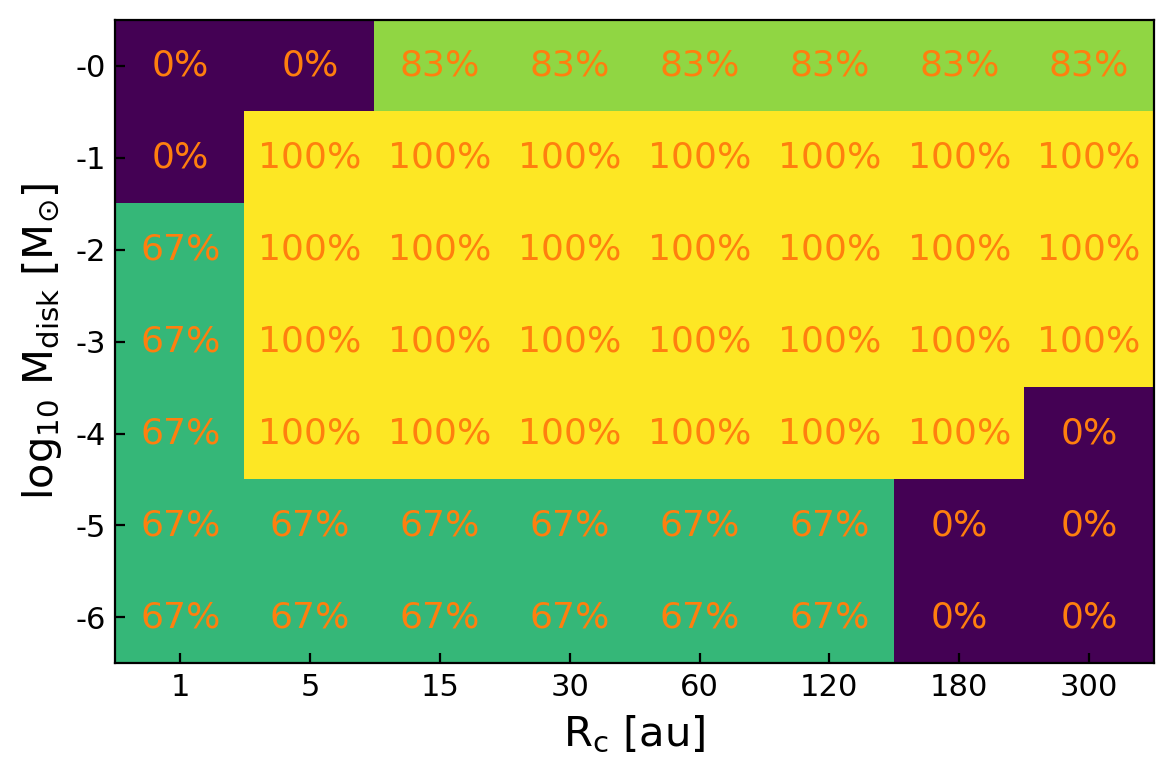


---per mass/Rc completeness---



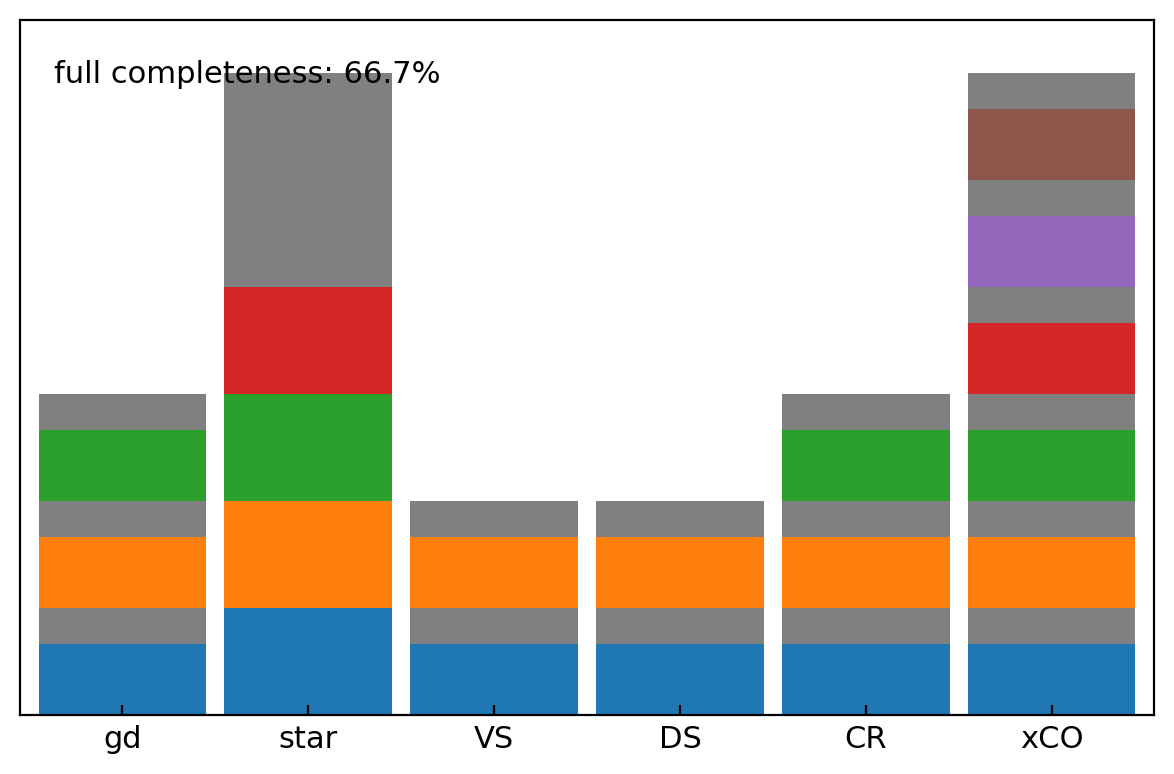

In [2]:
disk = DALI_modelgrid_interface(database,verbose=False,inclinations=0)
disk.make_flux_arrays(['13CO','32'])
print('\n---the full grid completeness---\n')
disk.plot_grid_completeness()
print('\n---per mass/Rc completeness---\n')
mass,Rc = 1e-5,30
disk.plot_axis_completeness(mass,Rc)


## What's in the CSV file?

Unsurpisingly, the first few columns of the file are the model parameters, followed by a large number of model outputs (i.e. synthetic observables). Broadly these fall into two categories, integrated fluxes and "measured sizes". For all synthetic observables the disk is assumed to be at a distance of 150 pc.

In terms of fluxes there are:
 - 12CO J=2-1,3-2
 - 13CO J=2-1,3-2
 - C18O J=2-1,3-2
 - C17O J=2-1,3-2
 - N2H+ J=3-2,4-3
 - [C I] 1-0 (at 492 GHz)
 - HD J=1-0,2-1
 - Continuum for 1, 3, 5, 7, 10, 30, 50, 70, 100, 300, 500, 700, 890, 1100, 1300 micron

In terms of sizes there are:
 * 12CO J=2-1,3-2
 * 13CO J=2-1,3-2
 * C18O J=2-1,3-2
 * C17O J=2-1,3-2
 * Continuum for 890, 1100, 1300 micron
"Size" here refers to as the radius that encloses X% of the flux measured from the integrated intensity map, where X here can be 50, 68, 90, 95%. These have all been measured using the "native" resolution of images (~0.02 arcsec) but also after the image has been convolved with 0.1, 0.2, 0.3 or 0.4 arcsec circular Gaussian beam.

For N2H+ a slightly different size is included, namely the radius where the azimuthally averaged intensity profile peaks. This is also do for the native image resolution and after convolution with the aformentioned circular Gaussian beams. These "sizes" were included for potentially measuring CO snowline locations (following e.g. Qi et al. 2013), but they have not been used in any scientific context yet. So use some caution when working with these sizes.

All of these observables have been measured assuming inclinations of 0, 50 and 80 degrees. 

In [3]:
## printing a list of all the integrated flux column names (for a single inclination)
for key in database.keys():
    if key.endswith('_Jy') and not 'Em' in key and 'incl50' in key: print(key)

F_cont_890.0_incl50_Jy
F_cont_1100.0_incl50_Jy
F_cont_1300.0_incl50_Jy
SED_incl50.0_fluxes_Jy
F_CI_1_incl50_Jy
F_CO_2_incl50_Jy
F_CO_3_incl50_Jy
F_13CO_2_incl50_Jy
F_13CO_3_incl50_Jy
F_C18O_2_incl50_Jy
F_C18O_3_incl50_Jy
F_C17O_2_incl50_Jy
F_C17O_3_incl50_Jy
F_HD_1_incl50_Jy
F_HD_2_incl50_Jy
F_cont_1.0_incl50_Jy
F_cont_3.0_incl50_Jy
F_cont_5.0_incl50_Jy
F_cont_7.0_incl50_Jy
F_cont_10.0_incl50_Jy
F_cont_30.0_incl50_Jy
F_cont_50.0_incl50_Jy
F_cont_70.0_incl50_Jy
F_cont_100.0_incl50_Jy
F_cont_300.0_incl50_Jy
F_cont_500.0_incl50_Jy
F_cont_700.0_incl50_Jy


# A short description of the code

The main part of the module `class_gridfit` is the python class `DALI_modelgrid_interface` that reads in the CSV and allows the user an easy way create numpy arrays of integrated fluxes and sizes for a part of the model grid parameter size (recommended) or the whole grid, filling the gaps with NaNs (not recommended!). Once at least one of these arrays has been created, the can create linear interpolater(s) for these fluxes/sizes, which can be used in a MCMC least squares fit of the observed fluxes/sizes.

The module also includes functions for calculating the prior, likelihood, and probability. Similar classes around the disk model grids from [Stapper et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...682A.149S/abstract) and [Miotello et al. 2016](https://ui.adsabs.harvard.edu/abs/2024A%26A...682A.149S/abstract) are also included. 


# Fitting a disk - an example

-------------------------   AATau   -------------------------
['mass', 'Rc', 'gd', 'star', 'VS', 'DS', 'CR', 'xCO']
checked transitions
collected keys
made array
done!
[]
AATau_split_V6_Lstar-prior_walkers480steps10000
steps 1000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:10<00:00,  2.32it/s]


steps 2000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:22<00:00,  2.61it/s]


steps 3000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:15<00:00,  2.66it/s]


steps 4000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:13<00:00,  2.68it/s]


steps 5000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


steps 6000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:04<00:00,  2.74it/s]


steps 7000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:02<00:00,  2.76it/s]


steps 8000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:56<00:00,  2.81it/s]


steps 9000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:55<00:00,  2.81it/s]


steps 10000 of 10000


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:53<00:00,  2.83it/s]


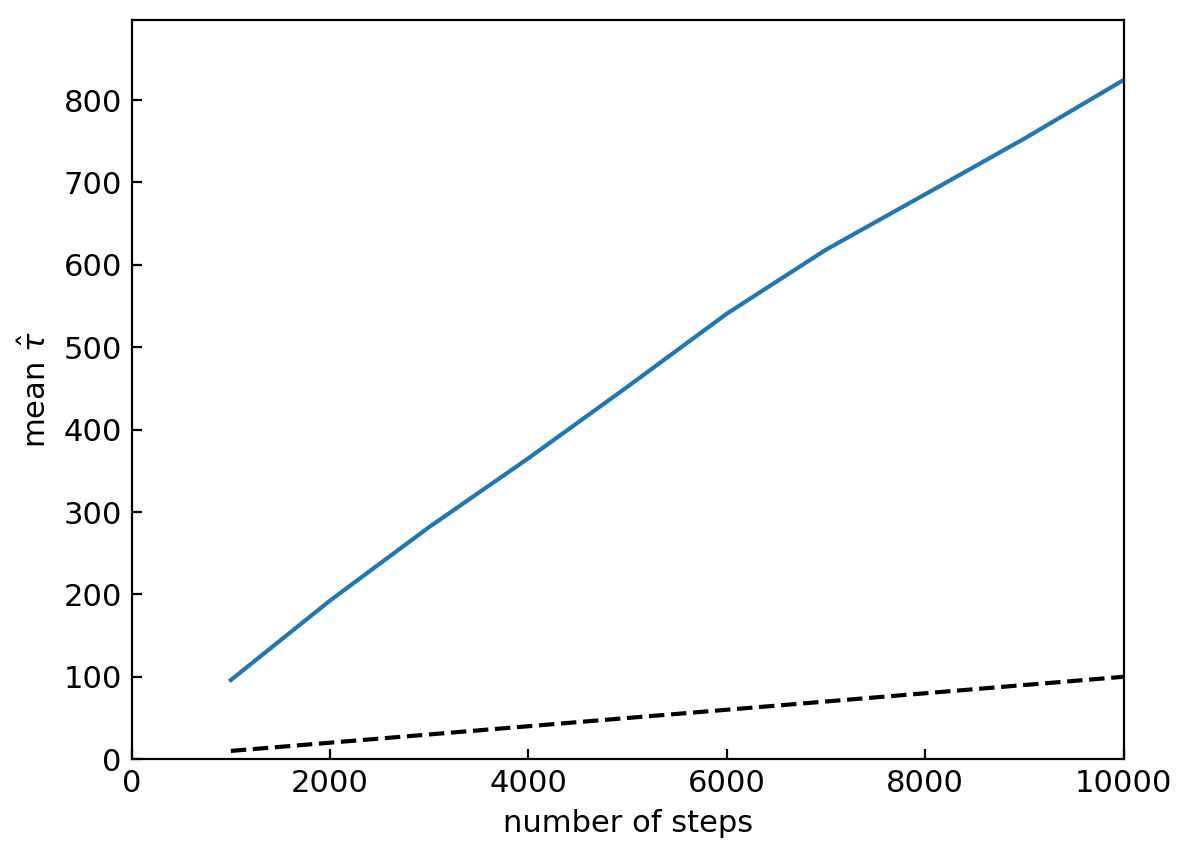

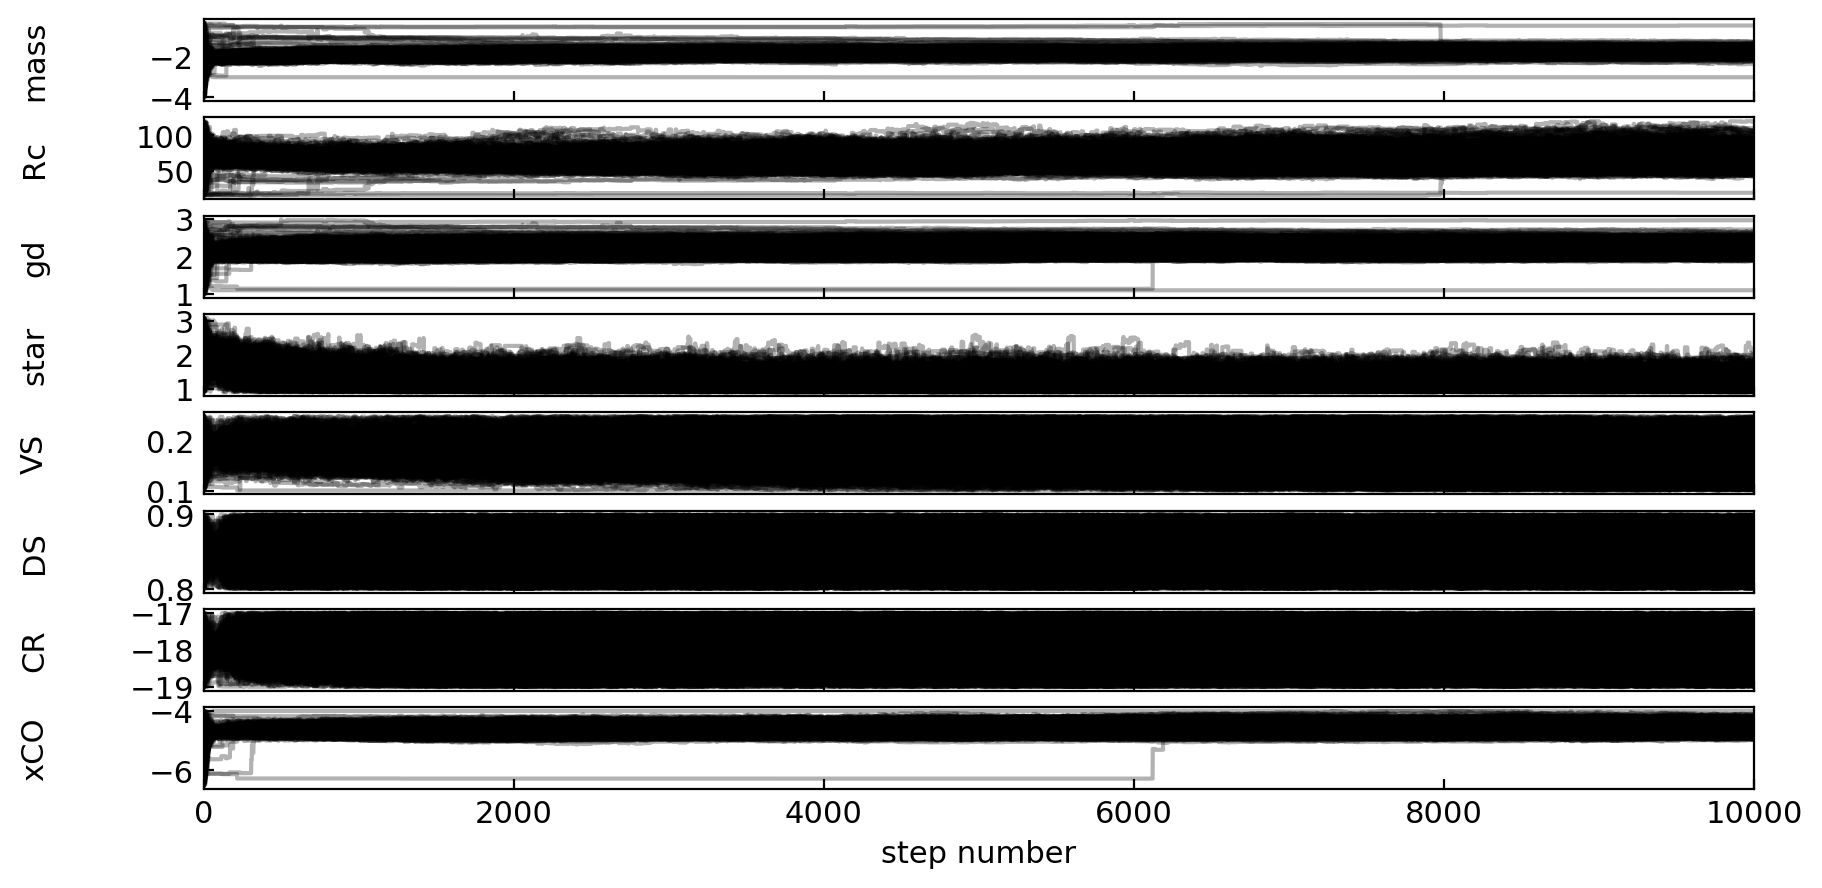

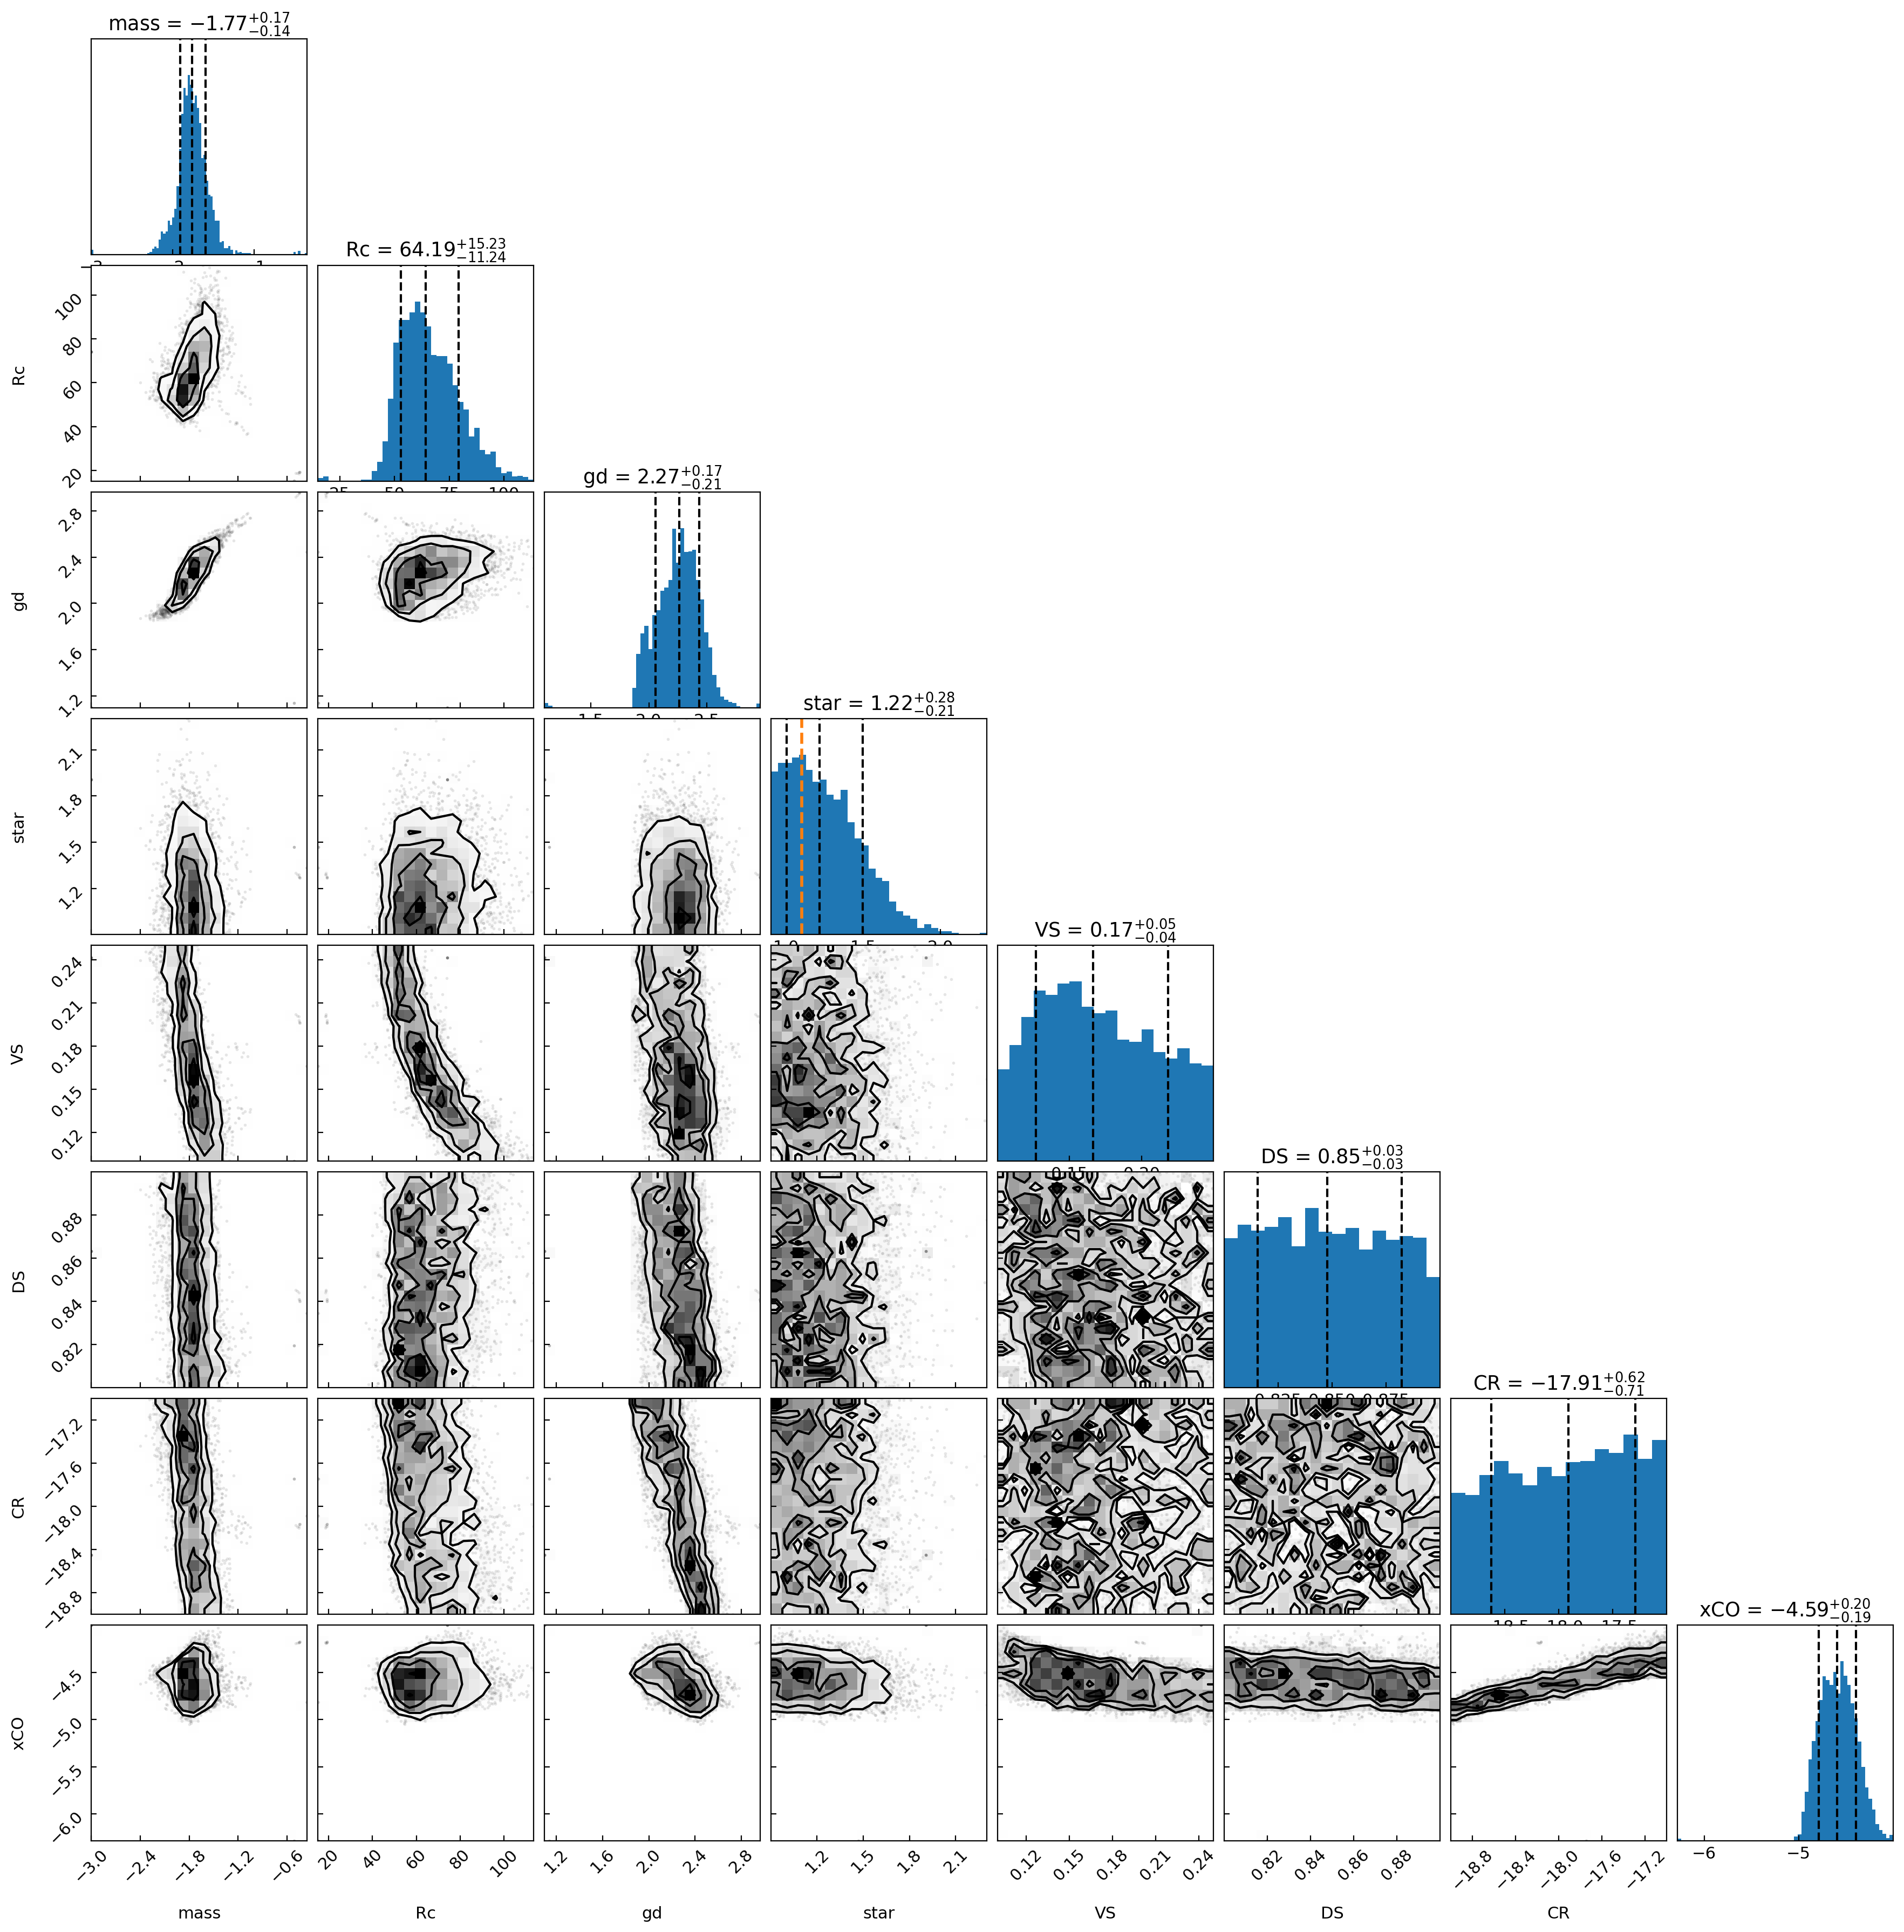

In [4]:
##### source properties
source = 'AATau'
print('-'*25,' ',source,' ','-'*25)
#### loading the source properties
inc   = 59            ## [deg] 
dist  = 135           ## [parcsec]
Lstar = 1.1           ## [Lsun]
errL  = 0.3*Lstar     ## [Lsun]

## observational properties
FtoL_obs = 4*np.pi*dist**2
# integrated fluxes
observations = {}
observations['flux_13CO_32']    = 5.102  ## 13CO J=3-2, in [Jy km/s]
observations['flux_C18O_32']    = 1.217  ## C18O J=3-2, in  [Jy km/s]
observations['flux_N2Hp_32']    = 0.606  ## N2H+ J=3-2, in  [Jy km/s]
observations['flux_cont285GHz'] = 0.112  ## 285 GHz, in [Jy]
observations['err_13CO_32']    = 0.042  ## 13CO J=3-2, in  [Jy km/s]
observations['err_C18O_32']    = 0.053  ## C18O J=3-2, in  [Jy km/s]
observations['err_N2Hp_32']    = 0.020  ## N2H+ J=3-2, in  [Jy km/s]
observations['err_cont285GHz'] = 0.0005 ## 285 GHz, in [Jy]

fluxes,err_fluxes = [],[]
for key in ['13CO_32','C18O_32','N2Hp_32','cont285GHz']:
    flux = observations['flux_'+key]*FtoL_obs
    err = observations['err_'+key]*FtoL_obs
    fluxes.append(flux)
    err_fluxes.append(np.sqrt(err**2 + (0.1*flux)**2))
# sizes
R13co90 = 1.74375*dist
e13co90 = 0.1*R13co90  ## just an estimate for now
round_beam = 0.1       ## size of the observation beam


## select a subset of the model parameter space
kwargs = {'rng_star':[0.9,3.1],   ## stellar luminosity, in [Lsun]
          'rng_Rc':[15,120],      ## characteristic radius, in [au]
          'rng_mdisk':[1e-4,0.5]} ## disk mass, in [Msun]
do_low_CR = False
if do_low_CR:
    kwargs['rng_cr'] = [1e-20,1e-18]  ## midplane ionization rate, in [s^-1]
else:
    kwargs['rng_cr'] = [1e-19,1e-17]

### dealing with inclination
if inc <= 30.:
    incl = [0] ## in [deg]
elif inc >= 65:
    incl = [80]
else:
    incl = [50]

## set up the grid
disk = DALI_modelgrid_interface(database,**kwargs,verbose=False,inclinations=incl)

## prepare the lines
lines =  ['13CO','C18O','N2Hp','CONT']
lines_info = [['13CO','32'],['C18O','32'],['HN2+','32'],['cont',1100.0]]

## make flux and size arrays
disk.make_flux_arrays(lines_info)
if fit_13CO_size: disk.make_size_arrays(['13CO','32',0.9,round_beam])
### make the interpolators    
if fit_13CO_size: 
    disk.make_interpolators(lines_info,sizes=['13CO','32',0.9,round_beam])
else:
    disk.make_interpolators(lines_info)

#### run the MCMC
nwalkers =  480
threads = 24
nsteps =   10000
small_steps = 1000
discard = 2500
thin = 1000
assert threads <= mp.cpu_count(),'requesting more threads than there are available on this machine [{} > {}]'.format(threads,mp.cpu_count())

## setting some choices for the MCMC
Lstar_obs_info = [Lstar,errL]  ## if this is set to None the code uses a uniform instead of a Gaussian prior for Lstar
if Lstar >=3.0: Lstar_obs_info = None
    
## creating paths for figures and files
base = os.path.join(path)
if not os.path.isdir(os.path.join(base,'MCMC')):
    os.makedirs(os.path.join(base,'MCMC'))
if not os.path.isdir(os.path.join(base,'corners')):
    os.makedirs(os.path.join(base,'corners'))

name = source+'_split_'
name +='V6_'
if Lstar_obs_info is not None:
    name += 'Lstar-prior_'
if do_lowCR:
    name +='lowCR_'
if fit_13CO_size:
    name +='fitR13CO_'
name += 'walkers{}'.format(nwalkers)
name += 'steps{}'.format(nsteps)
print('filename for output:',name)

if fit_13CO_size:
    mcmc_args = disk.return_mcmc_args(fluxes+[R13co90],err_fluxes+[eR13co90],['f']*len(fluxes)+['s'])
else:
    mcmc_args = disk.return_mcmc_args(fluxes,err_fluxes,['f']*len(fluxes))

## setting up initial conditions -- ['mass','Rc','gd','star','VS','DS','xCO','CR']
init_pos = disk.make_init_positions_walkers(nwalkers)
ndim = len(init_pos)
init_pos = np.array(init_pos)

## selecting probability function
log_prob = log_probability

## preparing the hdf5 backend
filename = os.path.join(base,name+".h5")
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
tau_per_small_steps = []

for curr_steps in np.arange(0,nsteps+1,small_steps)[1:]:
    print('steps {} of {}'.format(curr_steps,nsteps))
    backend = emcee.backends.HDFBackend(filename)
    if curr_steps==small_steps: 
        start_point = init_pos.T
    else:
        start_point = None
    
    if threads > 1:
        with Pool(processes=threads) as pool:
            sampler = emcee.EnsembleSampler(nwalkers,ndim,log_prob,
                                            args=mcmc_args,
                                            kwargs={'method':'linear',
                                                'Lstar_obs_info':Lstar_obs_info},
                                            pool=pool,backend=backend)
            sampler.run_mcmc(start_point,small_steps,progress=True)
    else:
        sampler = emcee.EnsembleSampler(nwalkers,ndim,log_prob,
                                        args=mcmc_args,
                                        kwargs={'method':'linear',
                                                'Lstar_obs_info':Lstar_obs_info},
                                        backend=backend)
        sampler.run_mcmc(start_point,small_steps,progress=True)
    tau_per_small_steps.append(sampler.get_autocorr_time(tol=0))

#### plot the progress of the autocorrelation time
n = np.arange(0,nsteps+1,small_steps)[1:]
y = np.mean(tau_per_small_steps,axis=1)
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")
plt.show()



#### make the figures
fig, axes = plt.subplots(ndim, figsize=(10, 5), sharex=True)
samples = sampler.get_chain()
labels = disk._keys
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

plt.show()

flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
## saving the output
np.save(os.path.join(base,'MCMC',name.replace('split','MCMC')+'_samples.npy'),flat_samples.T)

labels = disk._keys

quantiles = [0.16,0.5,0.84]
fig = corner.corner(flat_samples, labels=labels,fontsize=16,show_titles=True,quantiles = quantiles)

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    title = ax.get_title()
    xlim = ax.get_xlim()
    ## clear existing histogram while saving the rest
    ax.clear()
    ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ## redraw the histogram
    draws = flat_samples.T[i]
    val,_,_ = ax.hist(draws,bins='auto',histtype='stepfilled')
    ## redraw quantiles
    if len(quantiles) > 0:
        qvalues = np.quantile(draws,quantiles)
        for q in qvalues:
            ax.axvline(q,ls='--',color='k')
    if i ==3: ## the stellar posterior
        ax.axvline(Lstar,lw=2,ls='--',color='C1')
        #ax.fill_betweenx([0,1.2*np.nanmax(val)],Lstar - errL,Lstar + errL,color='C1',alpha=0.2)
    ax.set_ylim(0,1.2*np.nanmax(val))


## save the figure
fig.savefig(os.path.join(base,'corners',name.replace('split','corner')+'.pdf'))
plt.show()